# Проект Телеком

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**Задача** — обучить на этих данных модель для прогноза оттока клиентов.

In [1]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-02-26 21:11:13--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.6’

ds-plus-final.db.6  100%[===================>]   3.42M  --.-KB/s    in 0.06s   

2025-02-26 21:11:14 (52.9 MB/s) - ‘ds-plus-final.db.6’ saved [3588096/3588096]



In [2]:
!pip install phik -q
!pip install catboost -q
!pip install lightgbm -q
!pip install shap -q
!pip install keras -q

In [3]:
import os
import pandas as pd
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import shap
import time
import warnings

from datetime import datetime
from phik import phik_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from tensorflow import keras
from tensorflow.keras import layers

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 210224
TEST_SIZE = 0.25

## Знакомство с данными

In [5]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

In [6]:
def df_info(df):
  print('Первые 10 строк датафрейма:')
  display(df.head(10))
  print('')
  print(f'Размер датафрейма: {df.shape[0]} x {df.shape[1]}')
  print('')
  print('Общая информация:')
  print(df.info())
  print('')
  print('Статистическое описание количественных значений и дат:')
  display(df.describe())
  print('')
  print('Количество пропусков:')
  display(df.isnull().sum())

### Информация о договорах

In [7]:
contract = "SELECT * FROM contract;"
df_contract = pd.read_sql_query(contract, engine)

In [8]:
df_info(df_contract)

Первые 10 строк датафрейма:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.1,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.8,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35



Размер датафрейма: 7043 x 8

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB
None

Статистическое описание количественных значений и дат:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,67,3,2,4,1585,6658
top,5117-ZSMHQ,2014-02-01,No,Month-to-month,Yes,Electronic check,20.05,
freq,1,366,5942,3875,4171,2365,61,11



Количество пропусков:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Загружен датафрейм df_contract с информацией о договорах размером 7043 x 8 с столбцами:
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Пропуски в данных отсутствуют.\
Все данные, в том числе и количественные, имеют тип данных object, что требует внесения изменений.\
Также в столбце EndDate часто встречается значение "No", которое препятствует работе с датами. Так как информация о договорах актуальна на 1 февраля 2020, заменим все значения "No" на "2020-02-01".

### Персональные данные клиентов

In [9]:
personal = "SELECT * FROM personal;"
df_personal = pd.read_sql_query(personal, engine)

In [10]:
df_info(df_personal)

Первые 10 строк датафрейма:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



Размер датафрейма: 7043 x 5

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB
None

Статистическое описание количественных значений и дат:


,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043,7043
unique,7043,2,2,2,2
top,5117-ZSMHQ,Male,0,No,No
freq,1,3555,5901,3641,4933



Количество пропусков:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

Загружен датафрейм df_personal с информацией о договорах размером 7043 x 5 с столбцами:
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Пропуски в данных отсутствуют.\
Предварительно изменение типа данных не требуется.

### Информация об интернет услугах

In [11]:
internet = "SELECT * FROM internet;"
df_internet = pd.read_sql_query(internet, engine)

In [12]:
df_info(df_internet)

Первые 10 строк датафрейма:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



Размер датафрейма: 5517 x 8

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Статистическое описание количественных значений и дат:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,5117-ZSMHQ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785



Количество пропусков:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Загружен датафрейм df_internet с информацией об интернет услугах размером 5517 x 8 с столбцами:
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Пропуски в данных отсутствуют.
Предварительно изменение типа данных не требуется.

### Информация об услугах телефонии

In [13]:
phone = "SELECT * FROM phone;"
df_phone = pd.read_sql_query(phone, engine)

In [14]:
df_info(df_phone)

Первые 10 строк датафрейма:


,CustomerId,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



Размер датафрейма: 6361 x 2

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerId     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Статистическое описание количественных значений и дат:


,CustomerId,MultipleLines
count,6361,6361
unique,6361,2
top,5117-ZSMHQ,No
freq,1,3390



Количество пропусков:


CustomerId       0
MultipleLines    0
dtype: int64

Загружен датафрейм df_internet с информацией об интернет услугах размером 5517 x 8 с столбцами:
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Пропуски в данных отсутствуют.
Предварительно изменение типа данных не требуется.

### Вывод

Выгружено 4 датафрейма:
- df_contract — информация о договорах;
- df_personal — персональные данные клиентов;
- df_internet — информация об интернет-услугах;
- df_phone — информация об услугах телефонии.

Во всех таблицах отсутствуют пропуски.\
Предварительно изменения требутся только в df_contract:
- изменение типов данных в столбцах на соответствующие;
- изменение значений "No" в столбце EndDate на "2020-02-01".


## Исследовательский анализ и предобработка данных

### Предобработка данных

Проверим датафрейм на наличие аномалий EndDate < BeginDate.

In [15]:
len(df_contract[df_contract['EndDate'] < df_contract['BeginDate']])

0

Прверим количественные данные и даты датафрейма df_contract на наличие нечисловых символов.

In [16]:
# Проверка на наличие не числовых значений в "BeginDate"
df_contract.loc[
    df_contract['BeginDate'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'BeginDate'
].unique()

array([], dtype=object)

In [17]:
# Проверка на наличие не числовых значений в "BeginDate"
df_contract.loc[
    df_contract['EndDate'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'EndDate'
].unique()

array(['No'], dtype=object)

In [18]:
# Проверка на наличие не числовых значений в "BeginDate"
df_contract.loc[
    df_contract['MonthlyCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'MonthlyCharges'
].unique()

array([], dtype=object)

In [19]:
# Проверка на наличие не числовых значений в "BeginDate"
df_contract.loc[
    df_contract['TotalCharges'].str.contains(' |,|[a-z]|[A-Z]|[а-я]|[А-Я]'), 
    'TotalCharges'
].unique()

array([' '], dtype=object)

Обнаружены аномалии:
- значение 'No' в столбце EndDate с датами;
- пробелы в столбце TotalCharges.

In [20]:
df_contract[df_contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.0,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.7,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Как видно из выборки с пробелами в TotalCharges, это контракты, заключенные на 01.02.2024, то есть период оплаты еще не наступил. Целесообразно будет заменить пробелы на 0.\
Для того, чтобы привести данные EndDate к общему виду, заменим No на 2020-02-01.

In [21]:
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')
df_contract[['MonthlyCharges', 'TotalCharges']] = \
    df_contract[['MonthlyCharges', 'TotalCharges']].replace(' ', '0')

In [22]:
df_contract[['EndDate', 'BeginDate']] = df_contract[['EndDate', 'BeginDate']].astype('datetime64[ns]')
df_contract[['MonthlyCharges', 'TotalCharges']] = df_contract[['MonthlyCharges', 'TotalCharges']].astype('float')
print(df_contract.dtypes)

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float64
TotalCharges               float64
dtype: object


### Исследовательский анализ

#### df_contract

In [23]:
# Графики для количественного признака
def plot_num(df, columns):
    n = len(columns)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 5 * n))

    for i, column in enumerate(columns):
        # Гистограмма
        sns.histplot(df[column], ax=axes[i, 0], kde=True)
        axes[i, 0].set_title(f'Гистограмма для {column}')

        # Ящик с усами
        sns.boxplot(x=df[column], ax=axes[i, 1])
        axes[i, 1].set_title(f'Ящик с усами для {column}')

    plt.tight_layout()
    plt.show()

In [24]:
def plot_cat(df, columns):
    for column in columns:
        print(f'Processing column: {column}')  # Отладочный вывод
        df.groupby(column).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
        #plt.gca().spines[['top', 'right']].set_visible(False)
        plt.tight_layout()
        plt.show()

In [25]:
contract_numcols = df_contract.select_dtypes(include=['float', 'int']).columns
contract_datecols = df_contract.select_dtypes(include=['datetime64[ns]']).columns
contract_catcols = df_contract.drop('customerID', axis=1).select_dtypes(include=['object']).columns.tolist()

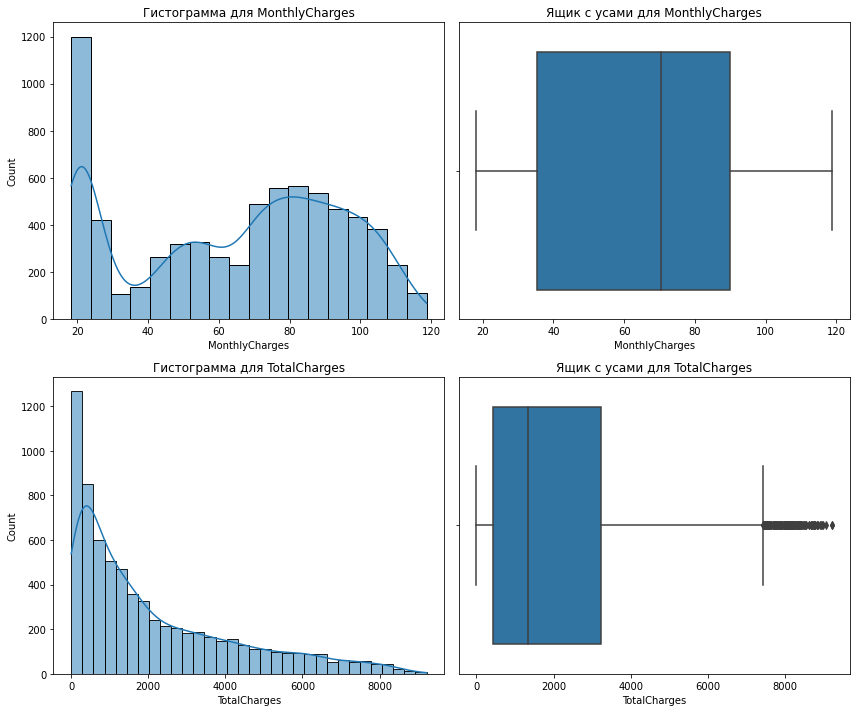

In [26]:
plot_num(df_contract, contract_numcols)

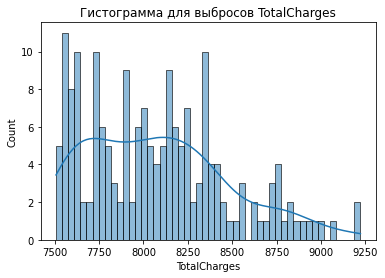

In [27]:
# Гистограмма выбросов MonthlyCharges
sns.histplot(df_contract[df_contract['TotalCharges'] > 7500]['TotalCharges'], kde=True, bins = 50)
plt.title(f'Гистограмма для выбросов TotalCharges');

Отсутствуют выбросы MonthlyCharges.\
Выбросы TotalCharges не выглядят аномальными, не будем их "отрезать".

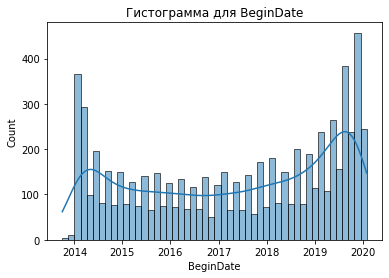

In [28]:
sns.histplot(df_contract['BeginDate'], kde=True, bins = 50)
plt.title(f'Гистограмма для BeginDate');

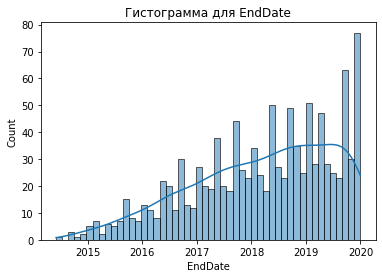

In [29]:
# Гистограмма выбросов MonthlyCharges
sns.histplot(df_contract[df_contract['EndDate'] != '2020-02-01']['EndDate'], kde=True, bins = 50)
plt.title(f'Гистограмма для EndDate');

Большинство контрактов заключено в начале и конце отчетного периода, к середине периода количество заключенных контрактов плавно снижается и затем также плавно возрастает.\
Количество закрытых контрактов с течением лет возрастает, что просто объясняется ростом общего количества контрактов.

Processing column: Type


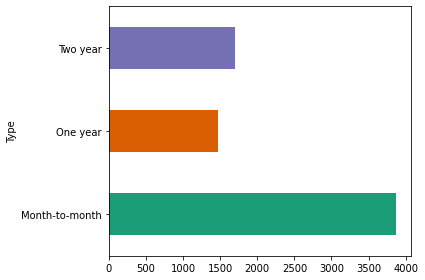

Processing column: PaperlessBilling


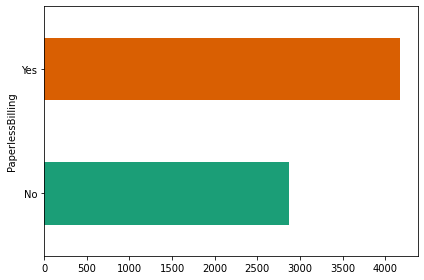

Processing column: PaymentMethod


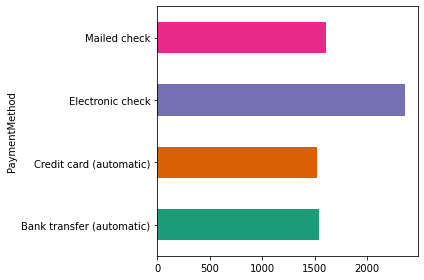

In [30]:
plot_cat(df_contract, contract_catcols)

#### df_personal

In [31]:
personal_catcols = df_personal.drop('customerID', axis=1).select_dtypes(include=['object']).columns

Processing column: gender


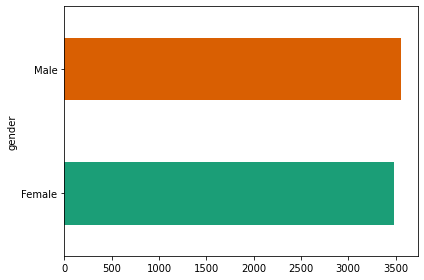

Processing column: SeniorCitizen


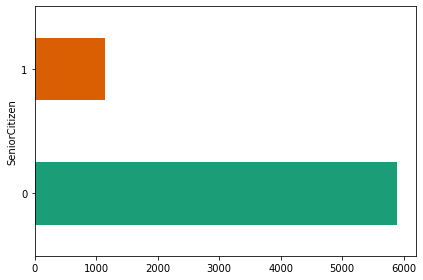

Processing column: Partner


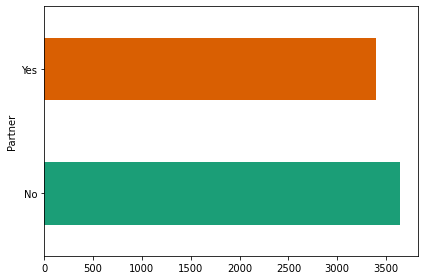

Processing column: Dependents


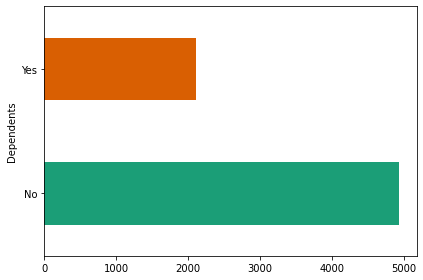

In [32]:
plot_cat(df_personal, personal_catcols)

#### df_internet

In [33]:
internet_catcols = df_internet.drop('customerID', axis=1).select_dtypes(include=['object']).columns

Processing column: InternetService


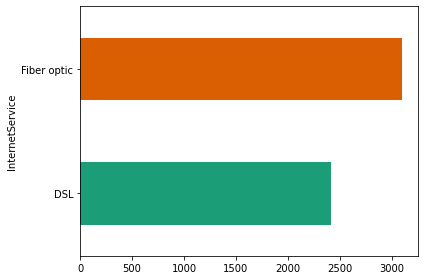

Processing column: OnlineSecurity


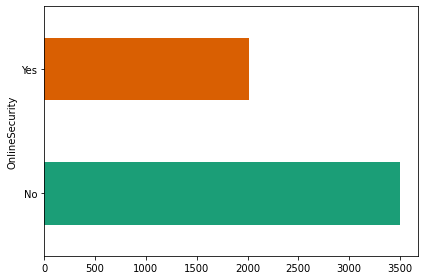

Processing column: OnlineBackup


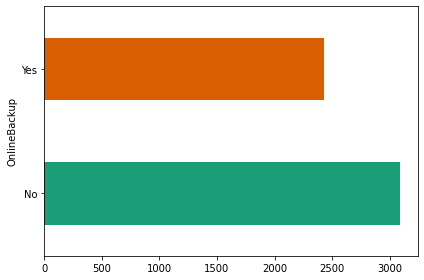

Processing column: DeviceProtection


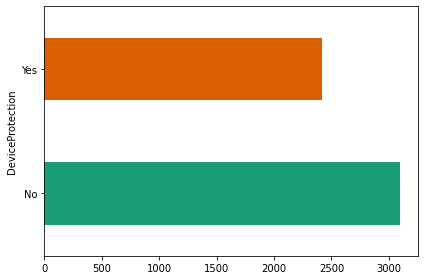

Processing column: TechSupport


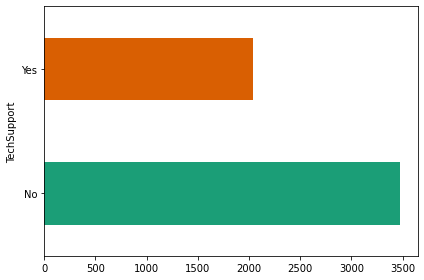

Processing column: StreamingTV


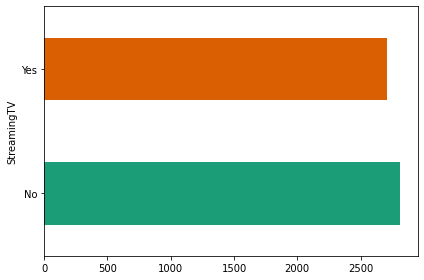

Processing column: StreamingMovies


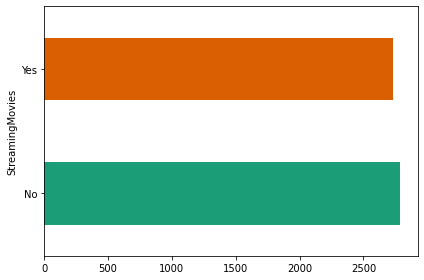

In [34]:
plot_cat(df_internet, internet_catcols)

#### df_phone

In [35]:
phone_catcols = df_phone.drop('CustomerId', axis=1).select_dtypes(include=['object']).columns

Processing column: MultipleLines


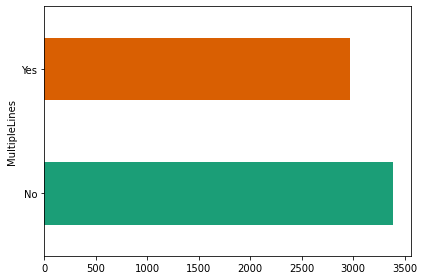

In [36]:
plot_cat(df_phone, phone_catcols)

### Объединение таблиц

In [37]:
def lower_case_columns(column):
    return column.str.lower()

In [38]:
df_contract.columns = lower_case_columns(df_contract.columns).to_list()
df_personal.columns = lower_case_columns(df_personal.columns).to_list()
df_internet.columns = lower_case_columns(df_internet.columns).to_list()
df_phone.columns = lower_case_columns(df_phone.columns).to_list()

In [39]:
df = pd.merge(df_contract, df_personal, on='customerid', how='left')
df = pd.merge(df, df_internet, on='customerid', how='left')
df = pd.merge(df, df_phone, on='customerid', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   datetime64[ns]
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   float64       
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   object        
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

### Создание дополнительных признаков

Создадим признак, который будет определять длительность контракта абонента.

In [44]:
df['duration'] = (df['enddate'] - df['begindate']).dt.days

Создадим **целевой признак**, который определит действует ли контракт.

In [45]:
def active(row):
    if row['enddate'] == datetime(2020, 2, 1):
        return 1
    else:
        return 0

In [46]:
df['active'] = df.apply(active, axis=1)

### Иссделовательский анализ df

In [47]:
df_numcols = df.select_dtypes(include=['float', 'int']).columns
df_datecols = df.select_dtypes(include=['datetime64[ns]']).columns
df_catcols = df.drop('customerid', axis=1).select_dtypes(include=['object']).columns

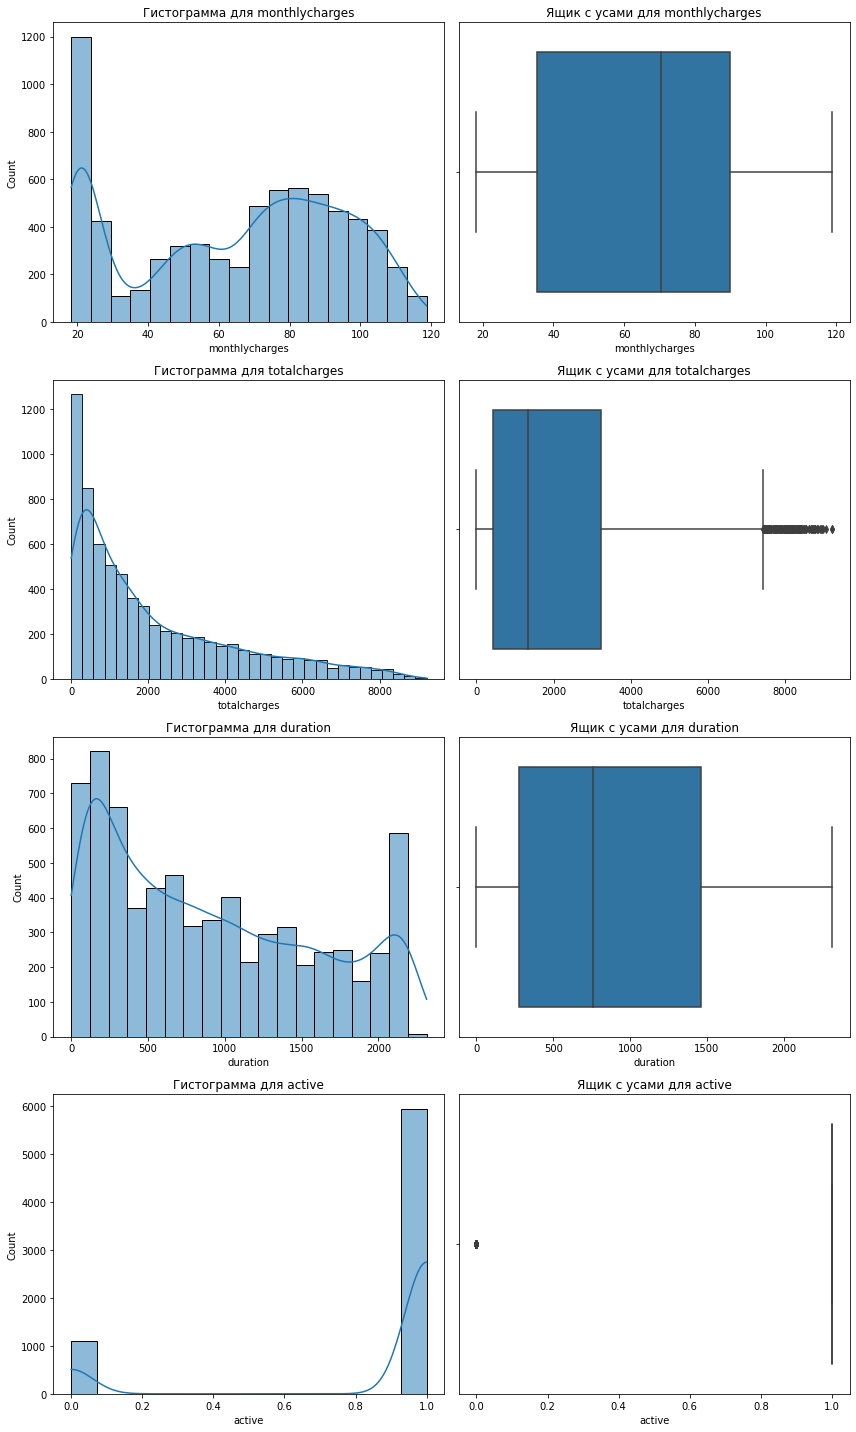

In [48]:
plot_num(df, df_numcols)

In [49]:
df.columns

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines', 'duration',
       'active'],
      dtype='object')

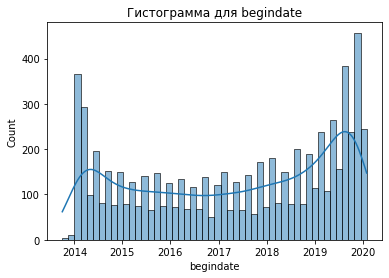

In [50]:
sns.histplot(df['begindate'], kde=True, bins = 50)
plt.title(f'Гистограмма для begindate');

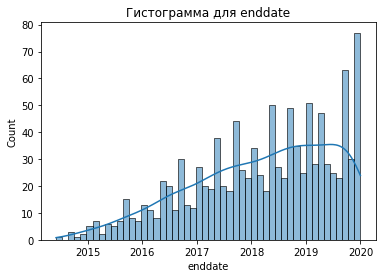

In [51]:
# Гистограмма выбросов MonthlyCharges
sns.histplot(df[df_contract['enddate'] != '2020-02-01']['enddate'], kde=True, bins = 50)
plt.title(f'Гистограмма для enddate');

Processing column: type


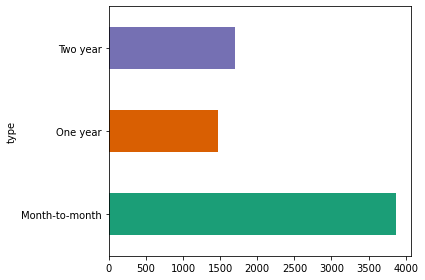

Processing column: paperlessbilling


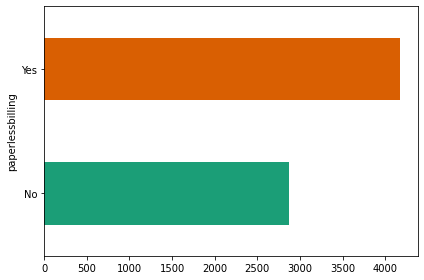

Processing column: paymentmethod


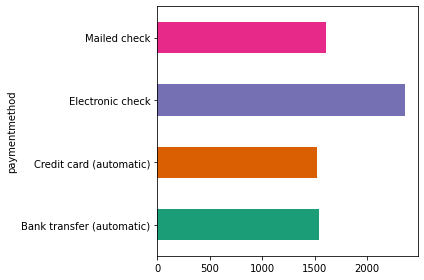

Processing column: gender


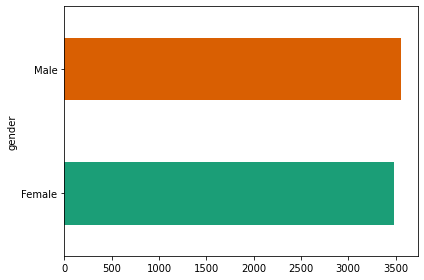

Processing column: seniorcitizen


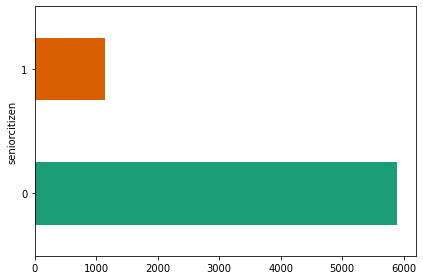

Processing column: partner


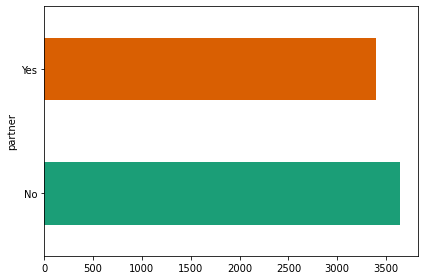

Processing column: dependents


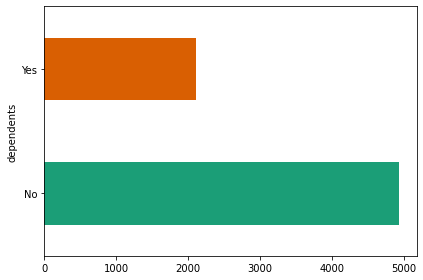

Processing column: internetservice


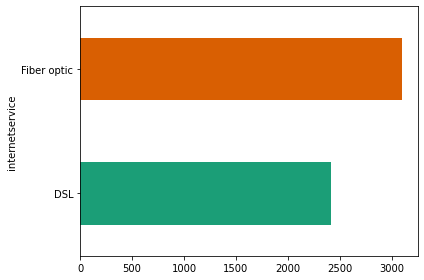

Processing column: onlinesecurity


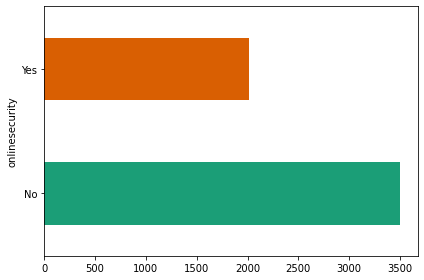

Processing column: onlinebackup


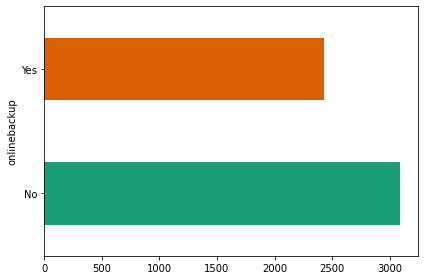

Processing column: deviceprotection


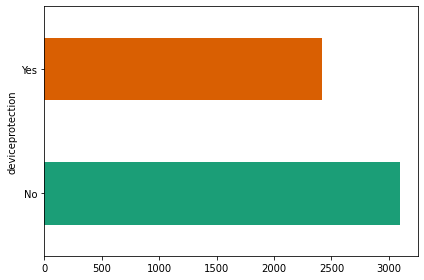

Processing column: techsupport


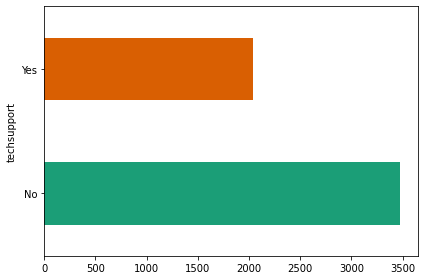

Processing column: streamingtv


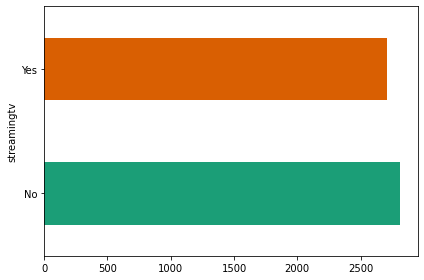

Processing column: streamingmovies


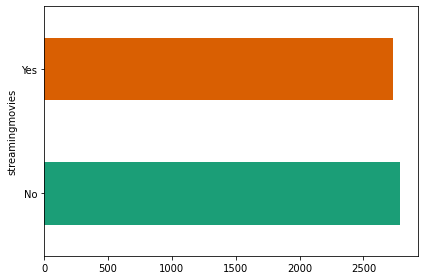

Processing column: multiplelines


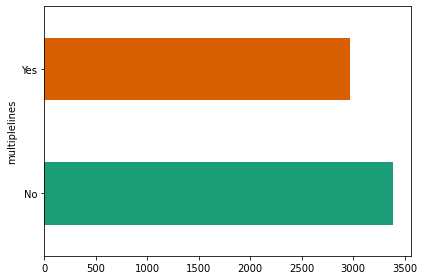

In [52]:
plot_cat(df, df_catcols)

### Корреляционный анализ

In [53]:
interval_cols = ['monthlycharges', 'totalcharges', 'duration']

Так как признаки customerid, begindate и endate не будут использоваться в модели обучения (перед нами не стоит задача временных рядов), то удалим их.

In [54]:
df = df.drop(['customerid', 'begindate', 'enddate'], axis=1)

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,duration,active
type,1.000000,0.106860,0.277462,0.388266,0.470860,0.000000,0.086231,0.179736,0.147680,0.115464,0.253529,0.195386,0.247180,0.293239,0.163095,0.167051,0.071275,0.634155,0.094015
paperlessbilling,0.106860,1.000000,0.370495,0.467783,0.201703,0.000000,0.242133,0.013218,0.172593,0.363514,0.215271,0.000000,0.029758,0.135913,0.182356,0.155905,0.269304,0.026799,0.083398
paymentmethod,0.277462,0.370495,1.000000,0.399536,0.335666,0.000000,0.292725,0.243008,0.224903,0.434448,0.365104,0.269205,0.297768,0.372982,0.247449,0.255010,0.369809,0.350964,0.214832
monthlycharges,0.388266,0.467783,0.399536,1.000000,0.711035,0.009025,0.304691,0.203237,0.184213,0.948738,0.364891,0.428024,0.495800,0.402669,0.733083,0.727985,0.475869,0.387579,0.225925
totalcharges,0.470860,0.201703,0.335666,0.711035,1.000000,0.000000,0.135650,0.381958,0.084247,0.301728,0.411771,0.514493,0.538299,0.444493,0.526653,0.525316,0.580930,0.848337,0.302890
gender,0.000000,0.000000,0.000000,0.009025,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.017842,0.003626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008581
seniorcitizen,0.086231,0.242133,0.292725,0.304691,0.135650,0.000000,1.000000,0.016992,0.324576,0.309469,0.170667,0.000000,0.000000,0.209633,0.047996,0.075309,0.237594,0.063315,0.086159
partner,0.179736,0.013218,0.243008,0.203237,0.381958,0.000000,0.016992,1.000000,0.652122,0.000000,0.265177,0.267471,0.290089,0.223082,0.239923,0.226459,0.232543,0.453688,0.226688
dependents,0.147680,0.172593,0.224903,0.184213,0.084247,0.000000,0.324576,0.652122,1.000000,0.206200,0.244955,0.150651,0.131018,0.212178,0.080593,0.030894,0.035777,0.198729,0.046871
internetservice,0.115464,0.363514,0.434448,0.948738,0.301728,0.000000,0.309469,0.000000,0.206200,1.000000,0.341950,0.008098,0.000000,0.326553,0.260564,0.246018,0.337835,0.059168,0.098956


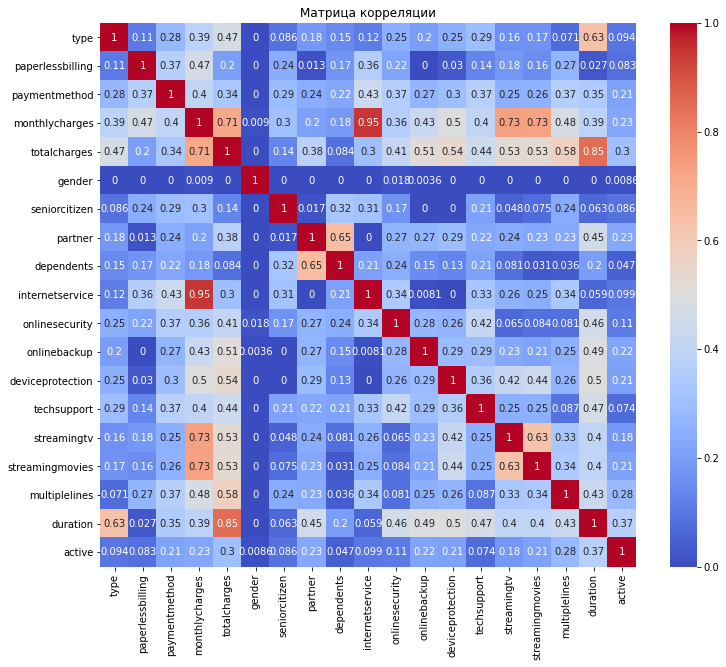

In [55]:
corr_matrix = df.phik_matrix(interval_cols=interval_cols)
display(corr_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции')
plt.show();

Признак gender практически не имеет никакой корреляции с другими признаками, удалим его, чтобы не загружать модель.


In [56]:
df = df.drop('gender', axis=1)

## Подготовка признаков и обучение модели

In [57]:
X = df.drop('active', axis=1)
y = df['active']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5282, 17)
(1761, 17)
(5282,)
(1761,)


In [59]:
categorical_features = ['type', 'paperlessbilling', 'paymentmethod', 'seniorcitizen', 'partner',
                        'dependents','internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                        'techsupport', 'streamingtv', 'streamingmovies', 'multiplelines']
numerical_features = ['monthlycharges', 'totalcharges', 'duration']

In [60]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

### LogisticRegression

In [61]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Регуляризация
    'classifier__penalty': ['l1', 'l2'],  # Тип регуляризации
}


grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)

In [62]:
start_time = time.time()

grid_search_lr.fit(X_train, y_train)

end_time = time.time()
execution_time_lr = end_time - start_time

print(f"Время обучения LogisticRegression: {execution_time_lr} секунд")
print("Лучшие параметры LogisticRegression:", grid_search_lr.best_params_)
print(f'Лучшая оценка на кросс-валидации LogisticRegression: {grid_search_lr.best_score_:.4f}')

Время обучения LogisticRegression: 15.437850713729858 секунд
Лучшие параметры LogisticRegression: {'classifier__C': 100, 'classifier__penalty': 'l1'}
Лучшая оценка на кросс-валидации LogisticRegression: 0.7581


### RandomForestClassifiier

In [63]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)

In [64]:
start_time = time.time()

grid_search_rf.fit(X_train, y_train)

end_time = time.time()
execution_time_rf = end_time - start_time

print(f"Время обучения RandomForestClassifiier: {execution_time_rf} секунд")
print("Лучшие параметры RandomForestClassifiier:", grid_search_rf.best_params_)
print(f'Лучшая оценка на кросс-валидации RandomForestClassifiier: {grid_search_rf.best_score_:.4f}')

Время обучения RandomForestClassifiier: 91.63478589057922 секунд
Лучшие параметры RandomForestClassifiier: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Лучшая оценка на кросс-валидации RandomForestClassifiier: 0.8219


### CatBoostClassifiier

In [65]:
pipeline_cb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier())
])

param_grid_cb = {
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__iterations': [100, 200]
}

grid_search_cb = GridSearchCV(pipeline_cb, param_grid_cb, cv=5, scoring='roc_auc', n_jobs=-1)

In [66]:
start_time = time.time()

grid_search_cb.fit(X_train, y_train)

end_time = time.time()
execution_time_cb = end_time - start_time

print(f"Время обучения CatBoostClassifiier: {execution_time_cb} секунд")
print("Лучшие параметры CatBoostClassifiier:", grid_search_cb.best_params_)
print(f'Лучшая оценка на кросс-валидации CatBoostClassifiier: {grid_search_cb.best_score_:.4f}')

0:	learn: 0.6856318	total: 48.2ms	remaining: 4.77s
1:	learn: 0.6785437	total: 49.6ms	remaining: 2.43s
2:	learn: 0.6711766	total: 51.1ms	remaining: 1.65s
3:	learn: 0.6655383	total: 52.1ms	remaining: 1.25s
4:	learn: 0.6595979	total: 53.5ms	remaining: 1.02s
5:	learn: 0.6544706	total: 54.3ms	remaining: 851ms
6:	learn: 0.6474301	total: 55.6ms	remaining: 739ms
7:	learn: 0.6410992	total: 57ms	remaining: 655ms
8:	learn: 0.6356965	total: 58.3ms	remaining: 589ms
9:	learn: 0.6307772	total: 59.7ms	remaining: 537ms
10:	learn: 0.6259129	total: 61ms	remaining: 494ms
11:	learn: 0.6202495	total: 62.7ms	remaining: 460ms
12:	learn: 0.6148430	total: 64.6ms	remaining: 432ms
13:	learn: 0.6100074	total: 66.4ms	remaining: 408ms
14:	learn: 0.6038876	total: 68ms	remaining: 386ms
15:	learn: 0.5982563	total: 69.7ms	remaining: 366ms
16:	learn: 0.5941677	total: 71.7ms	remaining: 350ms
17:	learn: 0.5882994	total: 73.2ms	remaining: 334ms
18:	learn: 0.5835297	total: 74.9ms	remaining: 320ms
19:	learn: 0.5784241	total: 

### LGBMClassifiier

In [67]:
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier())
])

param_grid_lgbm = {
    'classifier__num_leaves': [31, 50],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__n_estimators': [100, 200]
}

grid_search_lgbm = GridSearchCV(pipeline_lgbm, param_grid_lgbm, cv=5, scoring='roc_auc', n_jobs=-1)

In [68]:
start_time = time.time()

grid_search_lgbm.fit(X_train, y_train)

end_time = time.time()
execution_time_lgbm = end_time - start_time

print(f"Время обучения LGBMClassifiier: {execution_time_lgbm} секунд")
print("Лучшие параметры LGBMClassifiier:", grid_search_lgbm.best_params_)
print(f'Лучшая оценка на кросс-валидации LGBMClassifiier: {grid_search_lgbm.best_score_:.4f}')

Время обучения LGBMClassifiier: 36.80962657928467 секунд
Лучшие параметры LGBMClassifiier: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31}
Лучшая оценка на кросс-валидации LGBMClassifiier: 0.8708


### Neural Net (Keras)

In [69]:
X_transformed = preprocessor.fit_transform(X_train)
X_transformed.shape

(5282, 28)

In [70]:
model_nn = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=(X_transformed.shape[1],)),
    layers.Dense(1, activation='sigmoid')
])


model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

2025-02-26 21:16:11.440220: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [71]:
history = model_nn.fit(X_transformed, y_train, epochs=50, batch_size=32, validation_split=0.2)

y_val_pred = model_nn.predict(X_transformed[int(len(X_transformed) * 0.8):])

y_val_pred_classes = (y_val_pred > 0.5).astype(int)

roc_auc_nn = roc_auc_score(y_train[int(len(y_train) * 0.8):], y_val_pred)

print(f'ROC AUC на валидационной выборке: {roc_auc_nn:.4f}')


Epoch 1/50
133/133 [==============================] - 1s 4ms/step - loss: 0.5022 - accuracy: 0.8303 - val_loss: 0.4580 - val_accuracy: 0.8382
Epoch 2/50
133/133 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.8424 - val_loss: 0.4280 - val_accuracy: 0.8382
Epoch 3/50
133/133 [==============================] - 0s 2ms/step - loss: 0.4040 - accuracy: 0.8424 - val_loss: 0.4118 - val_accuracy: 0.8382
Epoch 4/50
133/133 [==============================] - 0s 4ms/step - loss: 0.3848 - accuracy: 0.8428 - val_loss: 0.3971 - val_accuracy: 0.8373
Epoch 5/50
133/133 [==============================] - 0s 3ms/step - loss: 0.3684 - accuracy: 0.8454 - val_loss: 0.3856 - val_accuracy: 0.8420
Epoch 6/50
133/133 [==============================] - 0s 2ms/step - loss: 0.3565 - accuracy: 0.8530 - val_loss: 0.3805 - val_accuracy: 0.8439
Epoch 7/50
133/133 [==============================] - 0s 3ms/step - loss: 0.3483 - accuracy: 0.8568 - val_loss: 0.3762 - val_accuracy: 0.8458
Epoch 

### Neural Net (torch)

In [72]:
X_train_tensor = torch.FloatTensor(X_transformed)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)

print(X_train_tensor.shape)
print(y_train_tensor.shape)

torch.Size([5282, 28])
torch.Size([5282, 1])


In [73]:
X_train, X_val, y_train, y_val = train_test_split(X_train_tensor, y_train_tensor, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [74]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 10000
best_roc_auc = 0.0

for epoch in range(num_epochs):
    model.train()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_predicted_probs = val_outputs.numpy()
        val_roc_auc = roc_auc_score(y_val, val_predicted_probs)

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val ROC-AUC: {val_roc_auc:.4f}')

    if val_roc_auc > best_roc_auc:
        best_roc_auc = val_roc_auc
        best_model_weights = model.state_dict()

Epoch [100/10000], Loss: 0.5409, Val ROC-AUC: 0.5488
Epoch [200/10000], Loss: 0.4858, Val ROC-AUC: 0.5113
Epoch [300/10000], Loss: 0.4685, Val ROC-AUC: 0.5087
Epoch [400/10000], Loss: 0.4608, Val ROC-AUC: 0.5159
Epoch [500/10000], Loss: 0.4562, Val ROC-AUC: 0.5277
Epoch [600/10000], Loss: 0.4529, Val ROC-AUC: 0.5416
Epoch [700/10000], Loss: 0.4502, Val ROC-AUC: 0.5555
Epoch [800/10000], Loss: 0.4478, Val ROC-AUC: 0.5689
Epoch [900/10000], Loss: 0.4456, Val ROC-AUC: 0.5813
Epoch [1000/10000], Loss: 0.4436, Val ROC-AUC: 0.5929
Epoch [1100/10000], Loss: 0.4417, Val ROC-AUC: 0.6031
Epoch [1200/10000], Loss: 0.4399, Val ROC-AUC: 0.6119
Epoch [1300/10000], Loss: 0.4382, Val ROC-AUC: 0.6198
Epoch [1400/10000], Loss: 0.4365, Val ROC-AUC: 0.6275
Epoch [1500/10000], Loss: 0.4350, Val ROC-AUC: 0.6351
Epoch [1600/10000], Loss: 0.4334, Val ROC-AUC: 0.6418
Epoch [1700/10000], Loss: 0.4320, Val ROC-AUC: 0.6474
Epoch [1800/10000], Loss: 0.4306, Val ROC-AUC: 0.6533
Epoch [1900/10000], Loss: 0.4293, Val

### Результаты обучения

In [75]:
results = {
    'ROC-AUC': [round(grid_search_lr.best_score_,3),
                round(grid_search_rf.best_score_,3),
                round(grid_search_cb.best_score_,3),
                round(grid_search_lgbm.best_score_,3),
                round(roc_auc_nn,3),
                round(best_roc_auc,3)],
}
results = pd.DataFrame(results)
results.index = ['LogisticRegression',
                 'RandomForestClassifier',
                 'CatBoostClassifier',
                 'LGBMClassifier',
                 'NeuralNet (keras)',
                 'NeuralNet (torch)']

display(results)

,ROC-AUC
LogisticRegression,0.758
RandomForestClassifier,0.822
CatBoostClassifier,0.905
LGBMClassifier,0.871
NeuralNet (keras),0.787
NeuralNet (torch),0.752


Лучшей моделью на кросс-валидации оказалось CatBoostClassifier с значением метрики ROC-AUC = 0.912. Значит проводить тестирование будем на ней.

## Тестирование модели

In [76]:
y_pred_proba = grid_search_cb.predict_proba(X_test)[:, 1]
y_pred = grid_search_cb.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

ROC AUC: 0.9054902734762454
Accuracy: 0.9204997160704146


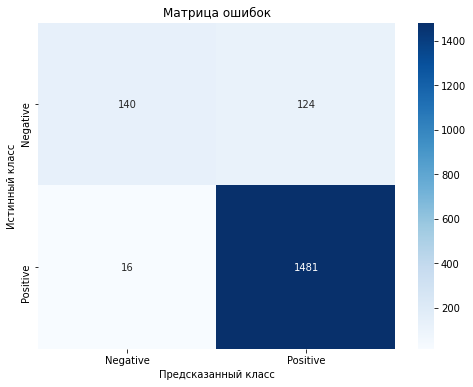

In [77]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.show()

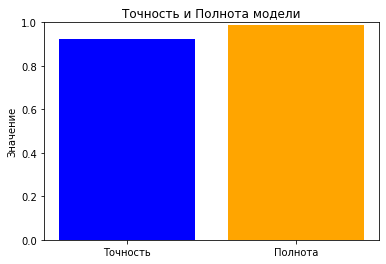

In [78]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

metrics = [precision, recall]
metrics_names = ['Точность', 'Полнота']

plt.figure(figsize=(6, 4))
plt.bar(metrics_names, metrics, color=['blue', 'orange'])
plt.ylim(0, 1)
plt.ylabel('Значение')
plt.title('Точность и Полнота модели')
plt.show()

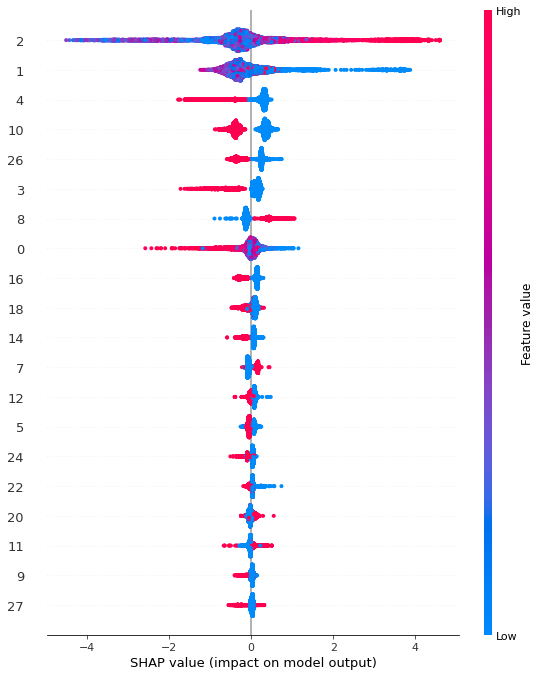

In [79]:
best_model = grid_search_cb.best_estimator_

catboost_model = best_model.named_steps['classifier']

X_transformed = best_model.named_steps['preprocessor'].transform(X)

explainer = shap.Explainer(catboost_model)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed, feature_names=catboost_model.feature_names_)

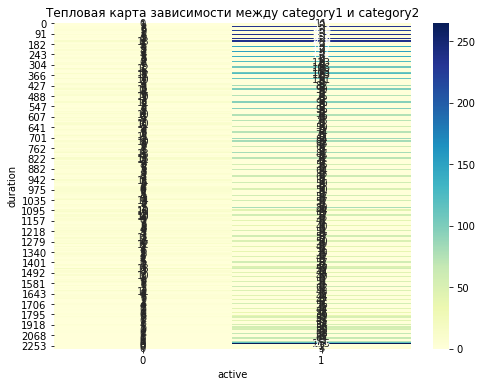

In [85]:
pivot_table = df.pivot_table(index='duration', columns='active', aggfunc='size', fill_value=0)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Тепловая карта зависимости между category1 и category2')
plt.xlabel('active')
plt.ylabel('duration')
plt.show()

**Вывод**
Подготовлены и обучены 4 модели и 2 нейронные сети со следющими результатами метрики ROC-AUC на кросс-валидации:
- LogisticRegression - 0.7581
- RandomForestClassifier - 0.8219
- CatBoostClassifier - 0.9050
- LGBMClassifier - 0.8708
- нейронная сеть (keras) - 0.7871
- нейронная сеть (torch) - 0.7520

По результатам обучения для тестирования выбрана модель CatBoostClassifier с параметрами {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__learning_rate': 0.2} и оценкой на кросс-валидации 0.9050.

На этапе тестирования выбранная модель показала следующие результаты:
- ROC AUC: 0.91
- Accuracy: 0.92

## Вывод

На первом этапе проведено знакомство с данными:
- выполнено подключение к базе данных;
- выгружены 4 датафрейма и общая информация о данных в них.

На втором этапе проведен исследовательский анализ и предобраотка данных:
- Изменены типы данных;
- Исправлены аномальные данные в количественных признаках;
- Проведен исследовательский анализ, в рамках которого не были обнаружены аномалии;
- 4 датафрейма были объединены в один;
- Проведен корреляционный анализ.

На третьем этапе были подготовлены и обучены 4 модели и 2 нейронные сети со следющими результатами метрики ROC-AUC на кросс-валидации:
- LogisticRegression - 0.7581
- RandomForestClassifier - 0.8219
- CatBoostClassifier - 0.9050
- LGBMClassifier - 0.8708
- нейронная сеть (keras) - 0.7871
- нейронная сеть (torch) - 0.7520

По результатам обучения для тестирования выбрана модель CatBoostClassifier с параметрами {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__learning_rate': 0.2} и оценкой на кросс-валидации 0.9050.

На этапе тестирования выбранная модель показала следующие результаты:
- ROC AUC: 0.9054902734762454
- Accuracy: 0.9204997160704146

**Способы для дальнейшего улучшения модели**
- дополнительный подбор гиперпараметров.
- изменение (усложнение) архитектуры нейросетей.
- сбор и обучение модели/нейронной сети на новых данных.